# CNN для мультиклассового распознавания


In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling1D
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

In [3]:
import re
from random import shuffle
from glob import glob
import pandas as pd

all_files = glob('allfiles\\*.jpg')

In [4]:
all_f = []
for i in all_files:
    all_f.append(i.replace('allfiles'+'\\',''))
ff = pd.DataFrame(all_f, columns=['fname'])

ff - датафрейм чтобы проверить, что есть все файлы из загруженной таблицы; пустые записи удалим.

загрузим заранее подготовленный файл с классами и номером изображения

In [149]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

subj_list = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'recipes', 'religion', 'romance', 'science','science fiction']

df = pd.read_csv('title_cover.csv')
df['path'] = df.file.apply(lambda x: 'allfiles'+'\\'+x )
df.head()

,children,fantasy,medicine,music,mystery and detective stories,recipes,religion,romance,science,science fiction,cover_id,file,path
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575546.0,575546.jpg,allfiles\575546.jpg
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1981419.0,1981419.jpg,allfiles\1981419.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905279.0,905279.jpg,allfiles\905279.jpg
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1321813.0,1321813.jpg,allfiles\1321813.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2964863.0,2964863.jpg,allfiles\2964863.jpg


In [6]:
data = df.merge(ff, left_on='file', right_on='fname', how='inner') 
# inner,  чтобы взять те файлы, которые точно есть и папке с файлами и в df

In [7]:
X = data['path']
y = data[subj_list]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,  random_state = 888)

In [9]:
# найдем соотношение классов в train/test
for i in range(0, 10):
    print(subj_list[i], y_test[subj_list].sum()[i]/y_train[subj_list].sum()[i])

children 0.11712158808933003
fantasy 0.1086893344957861
medicine 0.10887772194304858
music 0.1248673505482844
mystery and detective stories 0.10802069857697283
recipes 0.16666666666666666
religion 0.10883257653434891
romance 0.11281289290204595
science 0.10606060606060606
science fiction 0.12089077412513255


In [10]:
# соотношение классов в train/test практически равномерное

In [11]:
Xtr, Xtst, ytr, ytst = list(np.array(X_train)), list(np.array(X_test)), np.array(y_train), np.array(y_test)

In [12]:
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return array  # предобработка для ResNet50

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, yy ,  batch_size = 32):    
    while True:
        #shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)               
                
            x = np.array([load_image(path) for path in files[i:j]])
            #for path in files[i:j]:
            #    print(re.match('[a-z]+\\\.+-romance', path), path)  # # [a-z]+\\\.+
            #y = np.array([1. if re.match('[a-z]+\\\.+-romance', path) else 0. for path in files[i:j]])
            y = yy
            #print(i, j)
            #print(len(x))
            #print(y)           
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [13]:
#shuffle(Xtr)  # перемешиваем обучающую выборку
train_val_split = 100 # число изображений в валидационной выборке
#validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))
validation_data = next(fit_generator(Xtr[:train_val_split], ytr[:train_val_split], train_val_split))

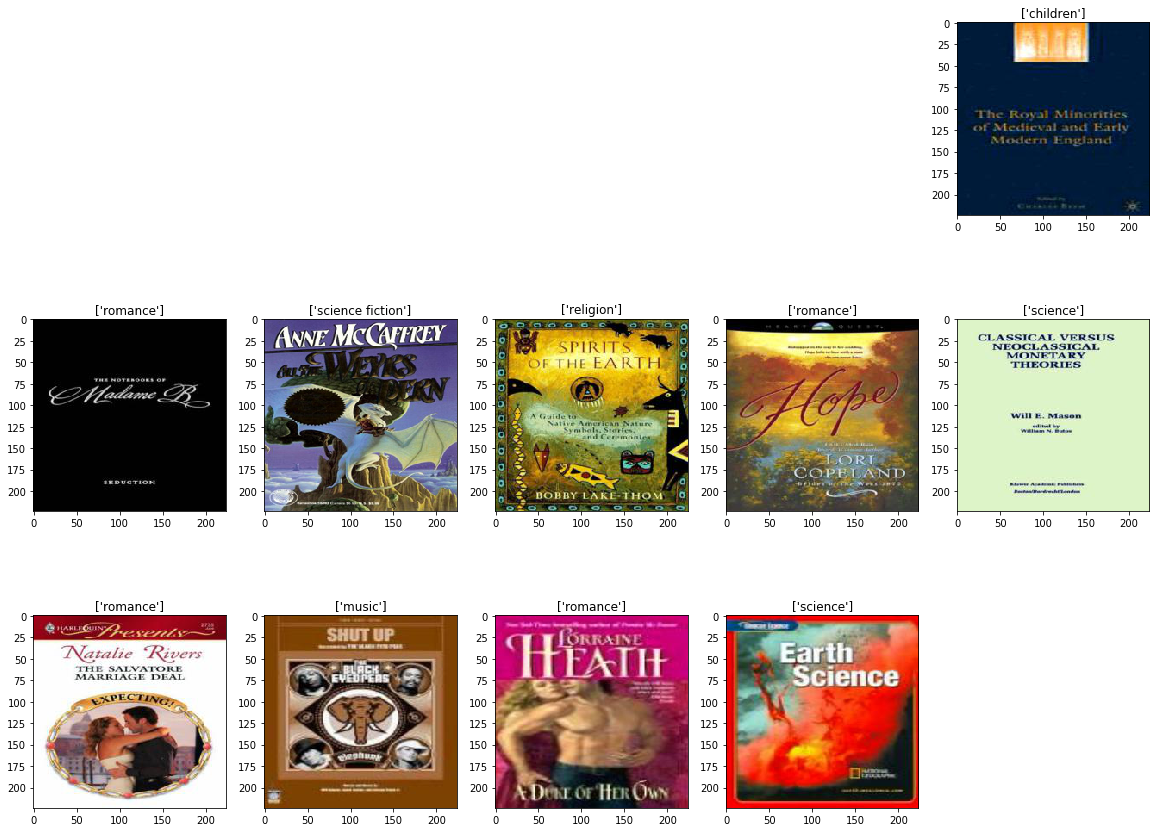

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11):
    #print(i, Xtr[i], ytr[i])
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(Xtr[i]));
    book_title = []
    for j in range(0, 10):
        if ytr[i,j] !=0:
            #print(j, subj_list[j])
            book_title.append(subj_list[j])
    subplot.set_title('%s' %  str(book_title)); # поправить вывод названия
    
plt.show()

In [180]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = True,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [181]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False
    
    
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [182]:
x = base_model.layers[-2].output

Конфигурация слоев варьировалась разнообразно, от одного Dense до нескольких, изменялись dropout, регуляризаторы и их параметры, слои ResNet из которого брался выход. Здесь представлен один из ночных прогонов.

In [183]:
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation = 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(10,  # один выход
                activation='softmax',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4)
                    )(x)
model = Model(inputs = base_model.input, outputs=x)

In [184]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [185]:
optimizer = Adam( lr=1e-5, beta_1= 0.8, beta_2 = 0.999)

In [186]:
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])
checkp = ModelCheckpoint(filepath='weights.best.cover.hdf5', 
                               verbose=1, save_best_only=True)

In [190]:
train_val_split = 100  # число изображений в валидационной выборке
validation_data = next(fit_generator(Xtr[:train_val_split], ytr[:train_val_split], train_val_split))

In [191]:
# запускаем процесс обучения
model.fit_generator(fit_generator(Xtr[train_val_split:], ytr[:train_val_split], train_val_split),  # данные читаем функцией-генератором
        steps_per_epoch=50,  # число вызовов генератора за эпоху
        epochs=150, class_weight = ww ,  # число эпох обучения
        validation_data=validation_data, workers = 0, use_multiprocessing=True, callbacks = [checkp])

Epoch 1/150
49/50 [============================>.] - ETA: 0s - loss: 0.6841 - acc: 0.1341
Epoch 00001: val_loss improved from inf to 2.27175, saving model to weights.best.cover.hdf5
50/50 [==============================] - 47s 943ms/step - loss: 0.6831 - acc: 0.1346 - val_loss: 2.2717 - val_acc: 0.1300
Epoch 2/150
49/50 [============================>.] - ETA: 0s - loss: 0.6235 - acc: 0.1580
Epoch 00002: val_loss improved from 2.27175 to 2.24832, saving model to weights.best.cover.hdf5
50/50 [==============================] - 29s 574ms/step - loss: 0.6236 - acc: 0.1582 - val_loss: 2.2483 - val_acc: 0.1500
Epoch 3/150
49/50 [============================>.] - ETA: 0s - loss: 0.6107 - acc: 0.1647
Epoch 00003: val_loss improved from 2.24832 to 2.24476, saving model to weights.best.cover.hdf5
50/50 [==============================] - 29s 575ms/step - loss: 0.6106 - acc: 0.1650 - val_loss: 2.2448 - val_acc: 0.1500
Epoch 4/150
49/50 [============================>.] - ETA: 0s - loss: 0.6076 - ac

Epoch 65/150
49/50 [============================>.] - ETA: 0s - loss: 0.5569 - acc: 0.1712
Epoch 00065: val_loss did not improve
50/50 [==============================] - 28s 564ms/step - loss: 0.5567 - acc: 0.1714 - val_loss: 2.3238 - val_acc: 0.1500
Epoch 66/150
49/50 [============================>.] - ETA: 0s - loss: 0.5537 - acc: 0.1759
Epoch 00066: val_loss did not improve
50/50 [==============================] - 28s 565ms/step - loss: 0.5538 - acc: 0.1760 - val_loss: 2.3184 - val_acc: 0.1500
Epoch 67/150
49/50 [============================>.] - ETA: 0s - loss: 0.5542 - acc: 0.1782
Epoch 00067: val_loss did not improve
50/50 [==============================] - 28s 566ms/step - loss: 0.5544 - acc: 0.1780 - val_loss: 2.3285 - val_acc: 0.1500
Epoch 68/150
49/50 [============================>.] - ETA: 0s - loss: 0.5502 - acc: 0.1769
Epoch 00068: val_loss did not improve
50/50 [==============================] - 28s 567ms/step - loss: 0.5502 - acc: 0.1768 - val_loss: 2.3163 - val_acc: 0.1

Epoch 98/150
49/50 [============================>.] - ETA: 0s - loss: 0.5375 - acc: 0.1914
Epoch 00098: val_loss did not improve
50/50 [==============================] - 28s 565ms/step - loss: 0.5373 - acc: 0.1920 - val_loss: 2.3371 - val_acc: 0.1500
Epoch 99/150
49/50 [============================>.] - ETA: 0s - loss: 0.5374 - acc: 0.1945
Epoch 00099: val_loss did not improve
50/50 [==============================] - 28s 567ms/step - loss: 0.5374 - acc: 0.1944 - val_loss: 2.3475 - val_acc: 0.1500
Epoch 100/150
49/50 [============================>.] - ETA: 0s - loss: 0.5337 - acc: 0.1867
Epoch 00100: val_loss did not improve
50/50 [==============================] - 28s 565ms/step - loss: 0.5339 - acc: 0.1860 - val_loss: 2.3460 - val_acc: 0.1500
Epoch 101/150
49/50 [============================>.] - ETA: 0s - loss: 0.5348 - acc: 0.1912
Epoch 00101: val_loss did not improve
50/50 [==============================] - 28s 565ms/step - loss: 0.5347 - acc: 0.1914 - val_loss: 2.3338 - val_acc: 0

Epoch 131/150
49/50 [============================>.] - ETA: 0s - loss: 0.5267 - acc: 0.2045
Epoch 00131: val_loss did not improve
50/50 [==============================] - 28s 566ms/step - loss: 0.5267 - acc: 0.2040 - val_loss: 2.3415 - val_acc: 0.1400
Epoch 132/150
49/50 [============================>.] - ETA: 0s - loss: 0.5245 - acc: 0.2020
Epoch 00132: val_loss did not improve
50/50 [==============================] - 28s 566ms/step - loss: 0.5243 - acc: 0.2018 - val_loss: 2.3425 - val_acc: 0.1500
Epoch 133/150
49/50 [============================>.] - ETA: 0s - loss: 0.5226 - acc: 0.2104
Epoch 00133: val_loss did not improve
50/50 [==============================] - 28s 567ms/step - loss: 0.5228 - acc: 0.2100 - val_loss: 2.3480 - val_acc: 0.1400
Epoch 134/150
49/50 [============================>.] - ETA: 0s - loss: 0.5211 - acc: 0.2096
Epoch 00134: val_loss did not improve
50/50 [==============================] - 28s 567ms/step - loss: 0.5205 - acc: 0.2102 - val_loss: 2.3435 - val_acc:

In [194]:
%%time
pred = model.predict_generator(predict_generator(Xtst), len(ytst), max_queue_size=500)

Wall time: 1min 35s


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[50:][:10], pred[50:][:10]), 1):
    subplot = fig.add_subplot(i // 5 +1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score + '  ' +'%s' % path[5:-4]);

In [195]:
np.around(pred[-10:])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)